In [1]:
# !pip3 install missingno

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import missingno
import os
import numpy as np
from scipy.signal import savgol_filter

In [4]:
try:
    owid_raw = pd.read_csv("raw_data/owid_raw.csv")
except: 
    owid_raw = pd.read_csv("https://covid.ourworldindata.org/data/owid-covid-data.csv")
try:
    who_global_raw = pd.read_csv("raw_data/who_global_raw.csv")
except: 
    who_global_raw = pd.read_csv("https://covid19.who.int/WHO-COVID-19-global-data.csv")
try:
    who_vac_meta_raw = pd.read_csv("raw_data/who_vac_meta_raw.csv")
except: 
    who_vac_meta_raw = pd.read_csv("https://covid19.who.int/who-data/vaccination-metadata.csv")
try:
    who_vac_raw = pd.read_csv("raw_data/who_vac_raw.csv")
except: 
    who_vac_raw = pd.read_csv("https://covid19.who.int/who-data/vaccination-data.csv")
try:
    who_phms_raw = pd.read_csv("raw_data/who_phms_raw.csv")
except: 
    who_phms_raw = pd.read_csv("https://covid19.who.int/who-data/phsm-severity-data.csv")

In [5]:
owid = owid_raw.add_prefix('owid__')
who_global = who_global_raw.add_prefix("who__")
who_vac_meta = who_vac_meta_raw.add_prefix("who_vac_meta__")
who_vac = who_vac_raw.add_prefix("who_vac__")
who_phms = who_phms_raw.add_prefix("who_phms__")

owid.owid__date = pd.to_datetime(owid.owid__date)
who_global.who__Date_reported = pd.to_datetime(who_global.who__Date_reported)
# owid.owid__location = owid.owid__location.str.lower()
# who_global.who__Country = who_global.who__Country.str.lower()
# owid.owid__location = owid.owid__location.str.strip()
# who_global.who__Country = who_global.who__Country.str.strip()


### Merge Owid and WHO Data

In [6]:
merged_dt_raw = pd.merge(owid, who_global, how='outer', 
                         left_on=['owid__date','owid__location'], 
                         right_on = ['who__Date_reported','who__Country'])
print(merged_dt_raw.shape)

(170227, 75)


In [17]:
merged_dt_raw['date'] = merged_dt_raw[["who__Date_reported", "owid__date"]].max(axis=1)
merged_dt_raw['country'] = merged_dt_raw[["owid__location" or "who__Country"]] # present in both dataset
merged_dt_raw["max_new_cases"] = merged_dt_raw[["owid__new_cases", "who__New_cases"]].max(axis=1)
merged_dt_raw['max_new_deaths'] = merged_dt_raw[['owid__new_deaths','who__New_deaths']].max(axis=1)

merged_dt_raw = merged_dt_raw[(merged_dt_raw.country.isna() == False) 
                                & (merged_dt_raw.owid__new_cases.isna() == False)
                                & (merged_dt_raw.owid__new_deaths.isna() == False)]

merged_dt_raw.sort_values(by=['country', 'date'], ascending=True, inplace=True)

# rolling mean to calculate moving average
merged_dt_raw['max_new_deaths_ma7'] = merged_dt_raw.groupby('country')['max_new_deaths'].transform(lambda x: x.rolling(10).mean())
merged_dt_raw['max_new_deaths_ma14'] = merged_dt_raw.groupby('country')['max_new_deaths'].transform(lambda x: x.rolling(14).mean())

# Savitzky-Golay filter
sgf_window = 151
sgf_poly = 5
merged_dt_raw['max_new_deaths_sgf'] = merged_dt_raw.groupby('country')['max_new_deaths'].transform(lambda x: savgol_filter(x, sgf_window, sgf_poly, mode='nearest'))
merged_dt_raw['max_new_cases_sgf'] = merged_dt_raw.groupby('country')['max_new_cases'].transform(lambda x: savgol_filter(x, sgf_window, sgf_poly, mode='nearest'))


In [18]:
print(merged_dt_raw.shape)

(103108, 83)


## Filter the dataset by country and date

In [19]:
merged_dt_filtrd = merged_dt_raw[(merged_dt_raw.country == "Germany") 
                                 & (merged_dt_raw.date >= "2021-01-01") 
                                #  & (merged_dt_raw.date < "2021-06-01")
                                 ]

### Use Savitzky-Golay filter to Smooth Data in Python

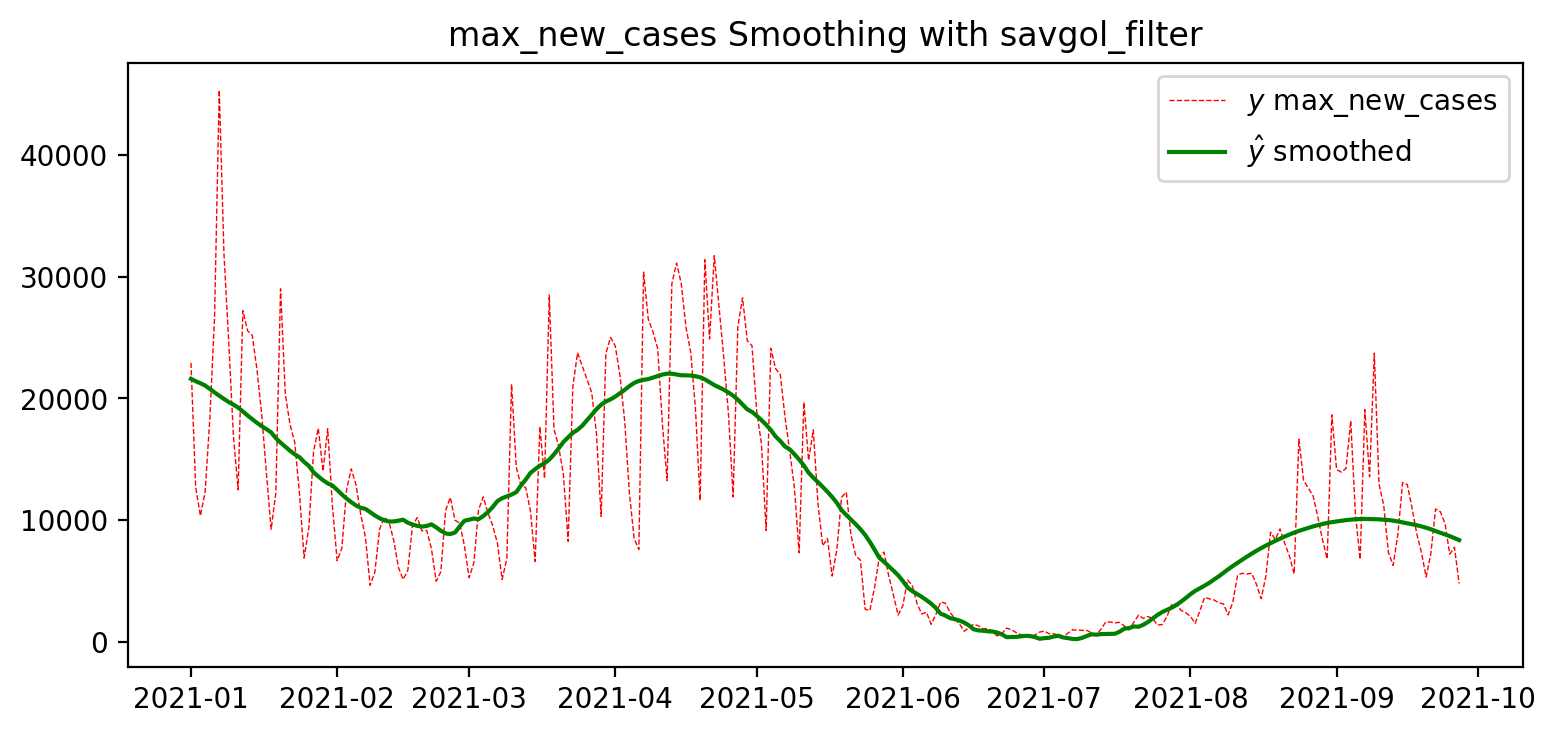

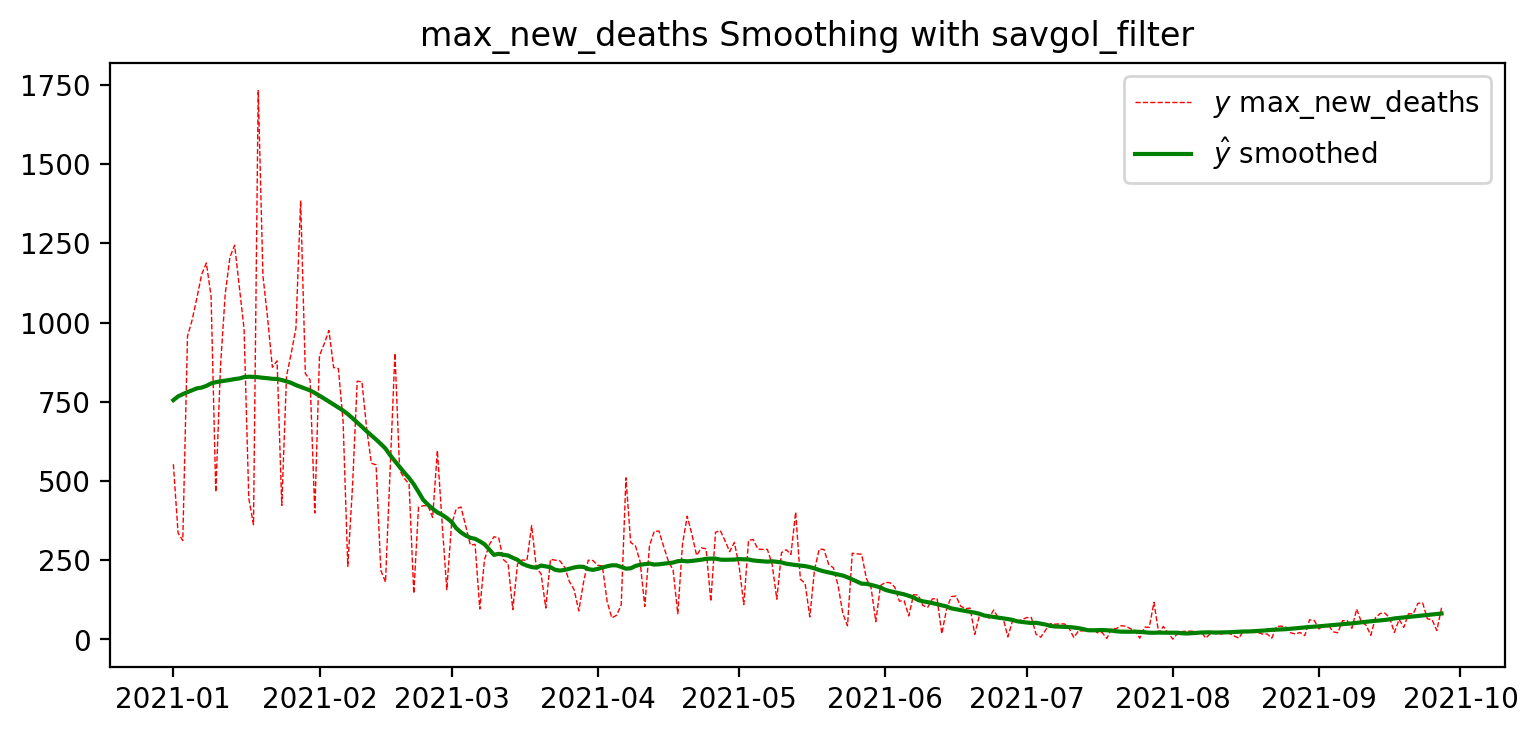

In [20]:
# merged_dt_filtrd['savgol'] = merged_dt_filtrd.groupby('country')['max_new_deaths'].transform(lambda x: savgol_filter(x, 5,2))
def smooth_plt(X, y, title = "Smoothing with savgol_filter"):
    yhat = savgol_filter(y, 101, 3, mode='nearest')

    figure(figsize=(9, 4), dpi=200)
    plt.plot(X, y, linestyle = "--", color='red', label= "$y$ "+str(y.name), linewidth=.5)
    plt.plot(X,yhat, color='green', label= "$\hat{y}$ smoothed")
    plt.legend()
    plt.title(title + " Smoothing with savgol_filter")
#     plt.grid()
    plt.show()

smooth_plt(merged_dt_filtrd['date'], merged_dt_filtrd['max_new_cases'], "max_new_cases")
smooth_plt(merged_dt_filtrd['date'], merged_dt_filtrd['max_new_deaths'], "max_new_deaths")

### Plotting smooth graph

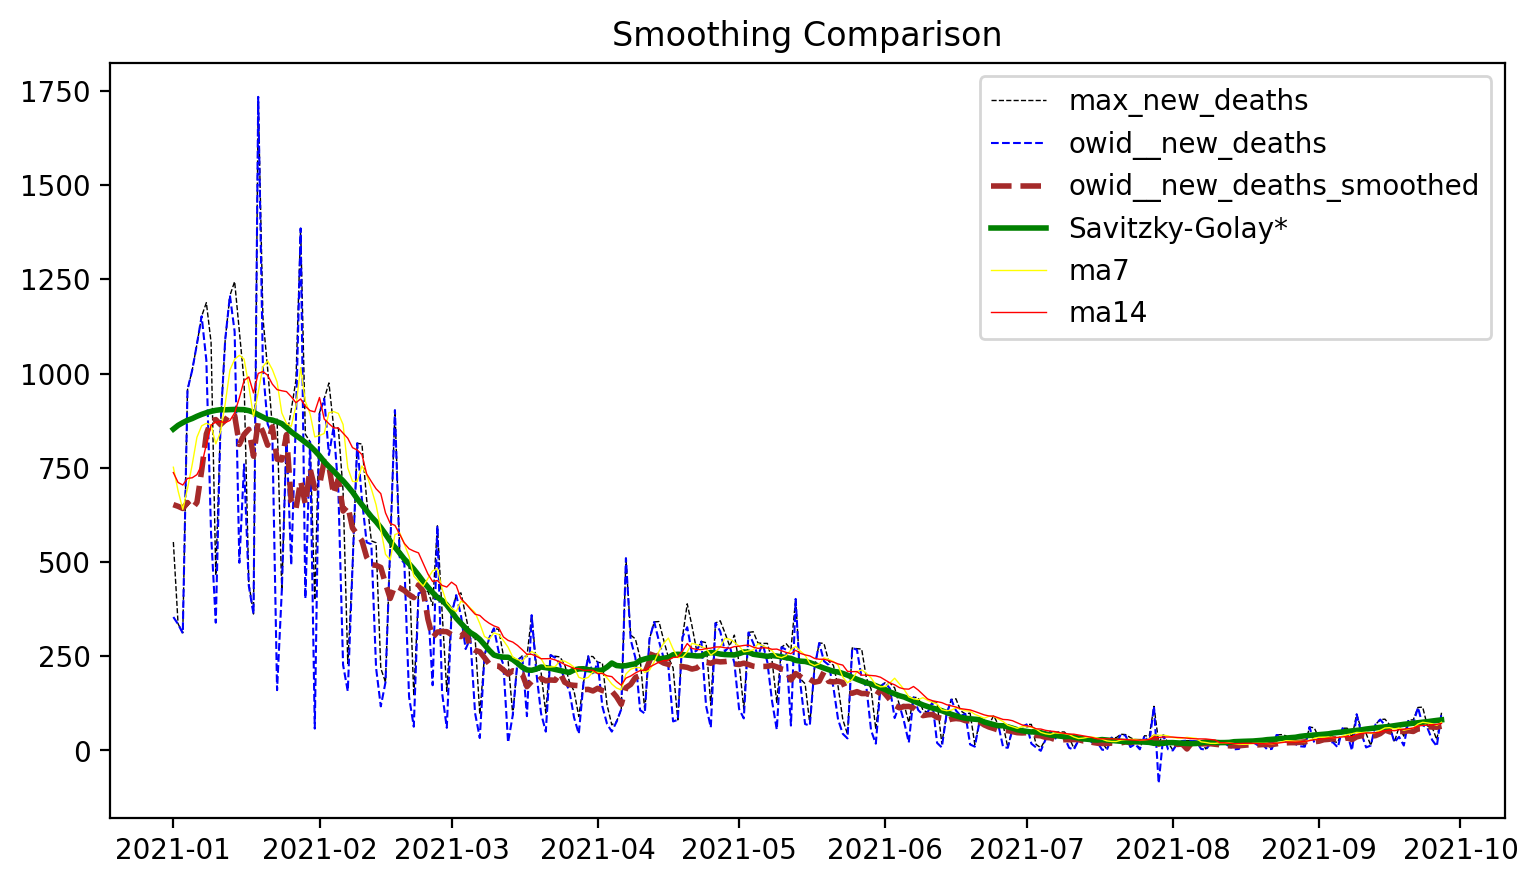

In [21]:
figure(figsize=(9, 5), dpi=200)
plt.title("Smoothing Comparison")
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["max_new_deaths"], linestyle = "--", color='black', label= "max_new_deaths", linewidth=.5)
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["owid__new_deaths"], linestyle = "--", color='blue', label= "owid__new_deaths", linewidth=.75)
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["owid__new_deaths_smoothed"], linestyle = "--", color='brown', label= "owid__new_deaths_smoothed", linewidth=2)
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["max_new_deaths_sgf"], color='green', label= "Savitzky-Golay*", linewidth=2)
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["max_new_deaths_ma7"], color='yellow', label= "ma7", linewidth=.5)
plt.plot(merged_dt_filtrd['date'], merged_dt_filtrd["max_new_deaths_ma14"], color='red', label= "ma14", linewidth=.5)
plt.legend()  

## Feature engineering

In [12]:
merged_dt_clean = merged_dt_raw[merged_dt_raw.date >= '2020-06-01']

merged_dt_clean = merged_dt_clean.drop(['who__Date_reported', 'owid__date', 'owid__location'
                    , 'who__Country',"owid__new_cases", "who__New_cases"
                    , 'owid__new_deaths','who__New_deaths'], axis = 1)

merged_dt_clean = merged_dt_clean.drop(merged_dt_clean.filter(like = 'umulativ').columns.tolist(), axis=1)
merged_dt_clean = merged_dt_clean.drop(merged_dt_clean.filter(like = 'moothe').columns.tolist(), axis=1)

top_100_country_lst = merged_dt_clean.country.value_counts().sort_values(ascending = False)[:100].index.tolist()

In [13]:
merged_dt_clean = merged_dt_clean[merged_dt_clean.country.isin(top_100_country_lst)]
a = round(1 - merged_dt_clean.count()/merged_dt_clean.shape[0], 2) * 100
a = a[a<=40] # filter for features with less than 30% missing values
good_features = a.sort_values(ascending=False)
good_features = good_features.index.tolist()
len(good_features)

37

<AxesSubplot:>

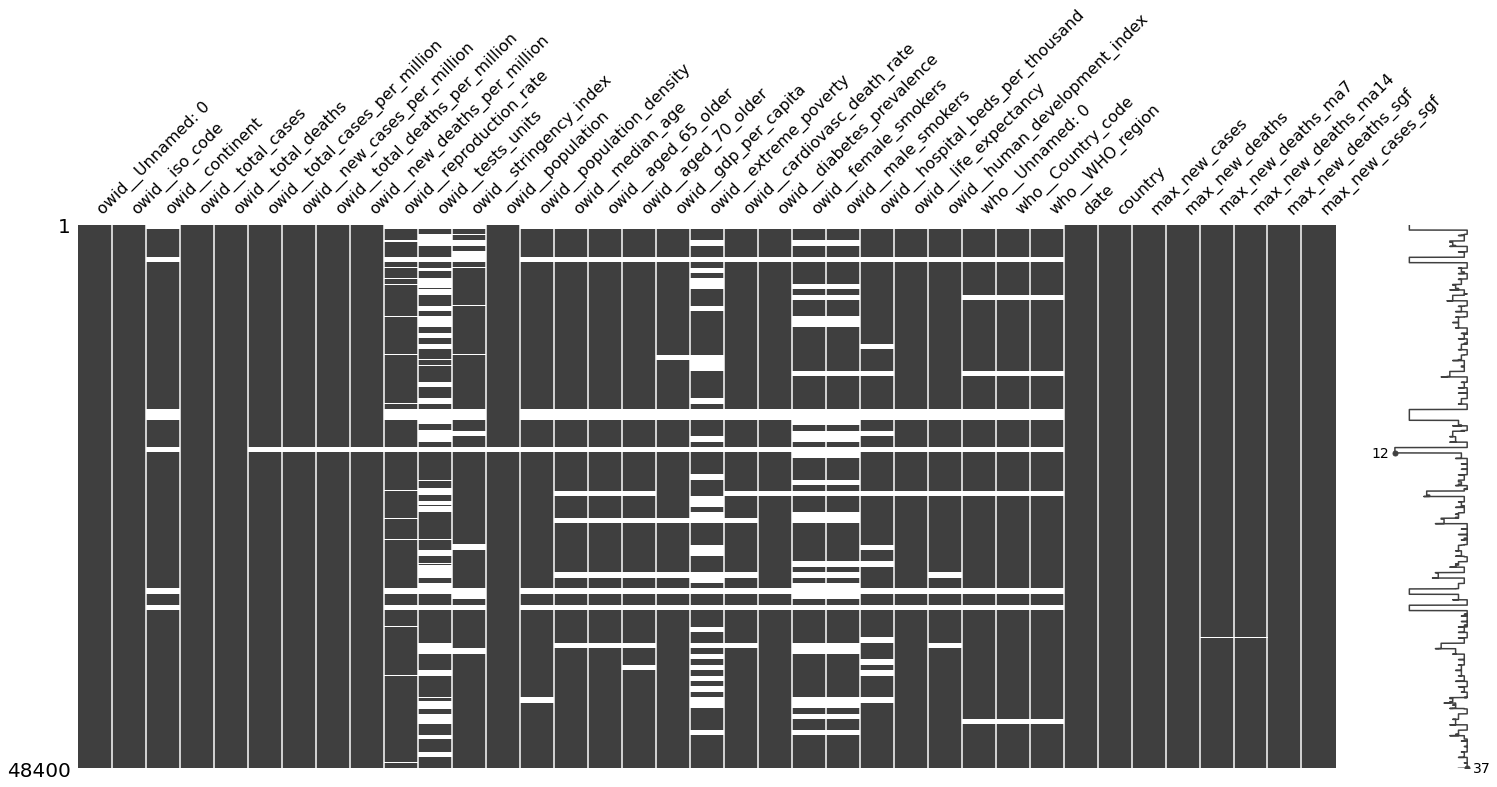

In [14]:
merged_dt_clean = merged_dt_clean.loc[:,merged_dt_clean.columns.isin(good_features)]
missingno.matrix(merged_dt_clean)

In [15]:
# seperate categorical and continuous variables
merged_dt_clean_conti_vars = merged_dt_clean.select_dtypes(include = ['float64', 'int64'])
merged_dt_clean_cat_vars = merged_dt_clean.select_dtypes(include = ['object'])

In [16]:
merged_dt_clean


,owid__Unnamed: 0,owid__iso_code,owid__continent,owid__total_cases,owid__total_deaths,owid__total_cases_per_million,owid__new_cases_per_million,owid__total_deaths_per_million,owid__new_deaths_per_million,owid__reproduction_rate,...,who__Country_code,who__WHO_region,date,country,max_new_cases,max_new_deaths,max_new_deaths_ma7,max_new_deaths_ma14,max_new_deaths_sgf,max_new_cases_sgf
691,691.0,OWID_AFR,NaN,152336.0,4343.0,110.912,4.212,3.162,0.088,NaN,...,NaN,NaN,2020-06-01,Africa,5785.0,121.0,116.0,108.000000,129.894187,5619.607449
692,692.0,OWID_AFR,NaN,157214.0,4493.0,114.463,3.552,3.271,0.109,NaN,...,NaN,NaN,2020-06-02,Africa,4878.0,150.0,123.8,113.357143,135.027524,5829.721970
693,693.0,OWID_AFR,NaN,162311.0,4601.0,118.174,3.711,3.350,0.079,NaN,...,NaN,NaN,2020-06-03,Africa,5097.0,108.0,124.7,115.071429,139.539934,5934.490844
694,694.0,OWID_AFR,NaN,169417.0,4756.0,123.348,5.174,3.463,0.113,NaN,...,NaN,NaN,2020-06-04,Africa,7106.0,155.0,127.7,118.642857,146.271421,6093.179166
695,695.0,OWID_AFR,NaN,176605.0,4913.0,128.582,5.233,3.577,0.114,NaN,...,NaN,NaN,2020-06-05,Africa,7188.0,157.0,132.2,123.571429,154.492279,6288.697665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119667,119667.0,ZWE,Africa,129134.0,4600.0,8556.357,21.866,304.794,0.530,NaN,...,ZW,AFRO,2021-09-23,Zimbabwe,618.0,23.0,9.0,8.642857,6.152374,343.343546
119668,119668.0,ZWE,Africa,129134.0,4600.0,8556.357,0.000,304.794,0.000,NaN,...,ZW,AFRO,2021-09-24,Zimbabwe,330.0,8.0,9.1,8.428571,5.804880,348.693351
119669,119669.0,ZWE,Africa,129505.0,4603.0,8580.939,24.582,304.993,0.199,NaN,...,ZW,AFRO,2021-09-25,Zimbabwe,371.0,3.0,8.7,7.857143,5.533330,352.688401
119670,119670.0,ZWE,Africa,129625.0,4604.0,8588.890,7.951,305.059,0.066,NaN,...,ZW,AFRO,2021-09-26,Zimbabwe,371.0,3.0,8.1,7.785714,5.312212,353.496715
